In [1]:
import argparse
import os
import random
import shutil
import time
import warnings
import json
import re
import copy

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.distributed as dist
import torch.optim
import torch.utils.data
import torch.utils.data.distributed
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, transforms


from utils.model_analysis_nets import LeNet, VGG16, ResNet20
from utils.load import getGradients, getTotalLength, mergeSublistsWithSharedItems, initDataset, minimizeProduct
from utils.load import getSamples, getTopofeature, extractWeights
from CKA import linear_CKA, kernel_CKA
import perscode

import numpy as np
import sympy
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.cluster.hierarchy import dendrogram, linkage, fcluster, fclusterdata
import scipy
import networkx as nx
import gif

from sklearn.manifold import MDS

import gudhi as gd
from ripser import Rips
from datetime import datetime


from sklearn.neighbors import KernelDensity
import numpy as np
import matplotlib.pyplot as plt

In [2]:


trans_mnist = transforms.Compose([transforms.ToTensor(),
                                  transforms.Normalize((0.1307,), (0.3081,))])
trans_cifar10_val = transforms.Compose([transforms.ToTensor(),
                                        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                             std=[0.229, 0.224, 0.225])])
dataset_test = datasets.CIFAR10('data/cifar10/', train=False, download=True, transform=trans_cifar10_val)
test_loader = torch.utils.data.DataLoader(
                dataset_test, batch_size=32,
                num_workers=2, pin_memory=True, shuffle=False)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
colors = ['r', 'g', 'b', 'y', 'p']
# attack_pth = "./LG-FedAvg/save_attack_ub/cifar10/resnet20_iidTrue_num100_C0.8_le2_DBAFalse/shard2/pattern07-25--14-29-32/local_attack_save/"
# normal_pth = "./LG-FedAvg/save_attack_ub/cifar10/resnet20_iidTrue_num100_C0.8_le2_DBAFalse/shard2/pattern07-25--14-29-32/local_normal_save/"
attack_pth = "/mnt/sda3/docker_space/Code/PHTDA-Net/LG-FedAvg/save_attack_ub/cifar10/resnet20_iidTrue_num100_C0.8_le2_DBATrue/shard2/pattern11-16--22-16-38/local_attack_save/"
normal_pth = "/mnt/sda3/docker_space/Code/PHTDA-Net/LG-FedAvg/save_attack_ub/cifar10/resnet20_iidTrue_num100_C0.8_le2_DBATrue/shard2/pattern11-16--22-16-38/local_normal_save/"
# attack_pth = "/mnt/sda3/docker_space/Code/PHTDA-Net/LG-FedAvg/save_attack_ub/cifar10/resnet20_iidTrue_num100_C0.8_le2_DBATrue/shard2/pattern12-16--19-06-13/local_attack_save/"
# normal_pth = "/mnt/sda3/docker_space/Code/PHTDA-Net/LG-FedAvg/save_attack_ub/cifar10/resnet20_iidTrue_num100_C0.8_le2_DBATrue/shard2/pattern12-16--19-06-13/local_normal_save/"


Files already downloaded and verified


In [3]:

round_set = []
client_set_attack = []
client_set_normal = []
modelpth_set = []
for dirpath, dirnames, filenames in os.walk(attack_pth):
    for filename in filenames:
        # if int(re.findall(r'-?\d+', filename)[0]) < round_max and int(re.findall(r'-?\d+', filename)[1]) < client_max:
        modelpth_set.append(os.path.join(dirpath, filename).replace("\\","/"))
        round_set.append(int(re.findall(r'-?\d+', filename)[0]))
        client_set_attack.append(int(re.findall(r'-?\d+', filename)[1]))

round_set = list(set(round_set))
client_set_attack = list(set(client_set_attack))

for dirpath, dirnames, filenames in os.walk(normal_pth):
    for filename in filenames:
        # if int(re.findall(r'-?\d+', filename)[0]) < round_max and int(re.findall(r'-?\d+', filename)[1]) < client_max:
        modelpth_set.append(os.path.join(dirpath, filename).replace("\\","/"))
        client_set_normal.append(int(re.findall(r'-?\d+', filename)[1]))

client_set_normal = list(set(client_set_normal))

print("rounds", round_set, len(round_set))
print("attack", client_set_attack, len(client_set_attack))
print("normal", client_set_normal, len(client_set_normal))
print(len(modelpth_set))

modelpth_dict = {}
for idx, r in enumerate(round_set):
    current_set_normal = []
    current_set_attack = []
    for mt in modelpth_set:
        # print(mt)
        if int(re.findall(r'-?\d+', mt)[-2]) == r and int(re.findall(r'-?\d+', mt)[-1]) in client_set_normal:
            # print(int(re.findall(r'-?\d+', mt)[-1]))
            current_set_normal.append(mt)
        if int(re.findall(r'-?\d+', mt)[-2]) == r and int(re.findall(r'-?\d+', mt)[-1]) in client_set_attack:
            # print(int(re.findall(r'-?\d+', mt)[-1]))
            current_set_attack.append(mt)
        
    modelpth_dict[f'{r}_normal'] = current_set_normal
    modelpth_dict[f'{r}_attack'] = current_set_attack
# print(modelpth_dict)
client_max = min(30,len(client_set_attack),len(client_set_normal))


modelname = ""
weight_keys_resnet = ["conv1.weight", "layer1.0.conv1.weight", "layer1.0.conv2.weight", "layer1.1.conv1.weight", "layer1.1.conv2.weight", "layer1.2.conv1.weight", "layer1.2.conv2.weight", "layer2.0.conv1.weight", "layer2.0.conv2.weight",
 "layer2.1.conv1.weight", "layer2.1.conv2.weight", "layer2.2.conv1.weight", "layer2.2.conv2.weight", "layer3.0.conv1.weight", "layer3.0.conv2.weight", "layer3.1.conv1.weight", "layer3.1.conv2.weight", "layer3.2.conv1.weight", "layer3.2.conv2.weight"]
weight_keys_resnet_reduced = ["layer3.0.conv1.weight"]

if "lenet" in attack_pth:
    modelname = "lenet"
    weightsize = 50
elif "VGG" in attack_pth:
    modelname = "vgg"
    weightsize = 64
elif "resnet" in attack_pth:
    modelname = "resnet"
    weightsize = 64
    weight_keys = weight_keys_resnet_reduced
else:
    assert 0==1


rounds [32, 34, 36, 22, 24, 26, 28, 30] 8
attack [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39] 40
normal [40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99] 60
640


In [5]:
now = datetime.now()
formatted_date_time = now.strftime("%Y-%m-%d-%H-%M-%S")

corr_set = []
normal_nums = int(client_max)
attack_nums = int(client_max/5)
total_nums = normal_nums+attack_nums

for idround, round_number in enumerate(round_set):
    if idround >= 1:
        break
    r_modelpth_set = modelpth_dict[f'{round_number}_normal'][0:normal_nums] + modelpth_dict[f'{round_number}_attack'][0:attack_nums]
    r_corr = np.zeros((total_nums, total_nums, 1))

    topofeaturelist = []
    gradientlist = []
    model, Dataloader, dataset = initDataset(modelname)
    for idx, modelp1 in enumerate(r_modelpth_set):
            gradientlist.append(getGradients(modelpth=modelp1, model=model, dataloader=Dataloader))
            topofeaturelist.append(getTopofeature(modelpth=modelp1, model=model, dataloader=Dataloader, dataset=dataset))

    vectors = zip(gradientlist, topofeaturelist)
    # for items in vectors:
    #     print(items)
    
    for id1, v1 in enumerate(copy.deepcopy(vectors)):
        if id1 >= total_nums:
            break
        for id2, v2 in enumerate(copy.deepcopy(vectors)):
            if id2 >= total_nums:
                break
            if id2 <= id1:
                continue
            
            
            corrlist = []

            # print(gradients1)
            acts1 = v1[0]["layer3.0.conv1.weight"]
            acts2 = v2[0]["layer3.0.conv1.weight"]
            acts1 = acts1.cpu().reshape((weightsize,-1))
            acts2 = acts2.cpu().reshape((weightsize,-1))
            fv1 = v1[1].reshape((5,-1))
            fv2 = v2[1].reshape((5,-1))
            # print(acts1-acts2)
            # print(fv1)
            l = linear_CKA(acts1.T, acts2.T)
            k = kernel_CKA(acts1.T, acts2.T)
            lfv = linear_CKA(fv1, fv2)
            kfv = linear_CKA(fv1, fv2)
            corrlist.append((l+k+lfv+kfv)/4)

            r_corr[id1][id2] = np.array(corrlist)
    
    corr_set.append([round_number, r_corr])

print(len(corr_set))
print(corr_set[0][1].shape)

Files already downloaded and verified
1
(36, 36, 1)


In [9]:
np.savetxt(f"./data/corrset_temp_v3_5_{formatted_date_time}.txt",np.array([row[1] for row in corr_set]).reshape(len(corr_set), -1))
print(formatted_date_time)

2024-01-10-19-29-49


In [10]:
now = datetime.now()
load_date_time = "2023-12-24 23:32:47"
file_path = f"./data/corrset_temp_{load_date_time}.txt"


corr_set_recovered = []
normal_nums = int(client_max)
attack_nums = int(client_max/5)
total_nums = normal_nums+attack_nums

total_rounds = len(round_set)
loaded_data = np.loadtxt(file_path)
corr_matrices = loaded_data.reshape(total_rounds, total_nums, total_nums, 1)

for idx, matrix in enumerate(corr_matrices):
    round_number = idx  # or fetch from a saved round number list if available
    corr_set_recovered.append([round_number, matrix])

if "formatted_date_time" not in globals() and "formatted_date_time" not in locals():
    corr_set = corr_set_recovered


# PCODE

In [7]:
from utils.pcode import isProperSuperset, findDifferentElements, flatten, findLargestGaps, grouping

32 (36, 36)


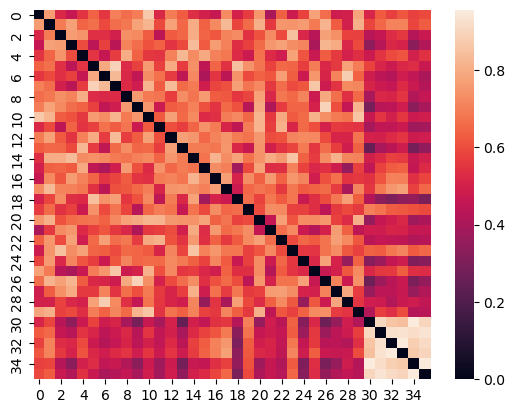

/opt/conda/envs/torch/lib/python3.8/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


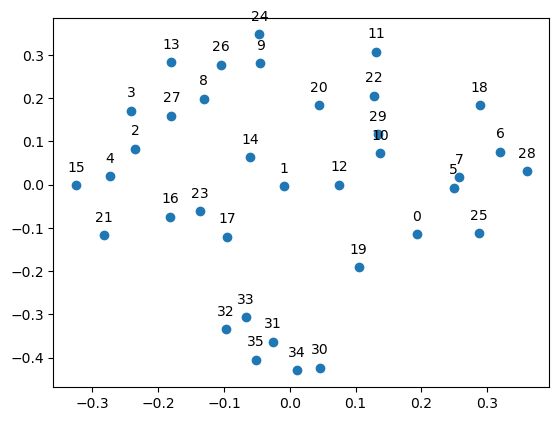

d 0 0 0.0 inf []
d 0 1 0.0 0.25819273167303614 [[5, 19]]
d 0 2 0.0 0.22858501291058708 [[17, 33]]
d 0 3 0.0 0.2241899222774426 [[24, 26]]
d 0 4 0.0 0.20781210609999667 [[4, 15]]
d 0 5 0.0 0.20608357261944732 [[8, 26]]
d 0 6 0.0 0.20165586322371187 [[14, 21]]
d 0 7 0.0 0.20001183301635272 [[4, 8]]
d 0 8 0.0 0.18897181286330544 [[11, 22]]
d 0 9 0.0 0.18643442780099706 [[14, 27]]
d 0 10 0.0 0.18509961038516054 [[14, 16]]
d 0 11 0.0 0.1839008652732681 [[11, 20]]
d 0 12 0.0 0.18287334713440773 [[9, 29]]
d 0 13 0.0 0.1826314575895822 [[7, 10]]
d 0 14 0.0 0.18003260425359957 [[3, 26]]
d 0 15 0.0 0.17957709959890744 [[10, 20]]
d 0 16 0.0 0.17857032633493186 [[1, 10]]
d 0 17 0.0 0.17362050196141354 [[4, 13]]
d 0 18 0.0 0.17065252946954113 [[1, 17]]
d 0 19 0.0 0.1684511935394174 [[6, 7]]
d 0 20 0.0 0.16438209185989505 [[7, 12]]
d 0 21 0.0 0.16144203614207964 [[3, 14]]
d 0 22 0.0 0.15465902309784385 [[5, 18]]
d 0 23 0.0 0.15281907496732594 [[2, 23]]
d 0 24 0.0 0.14456625826605574 [[14, 23]]
d 0 2

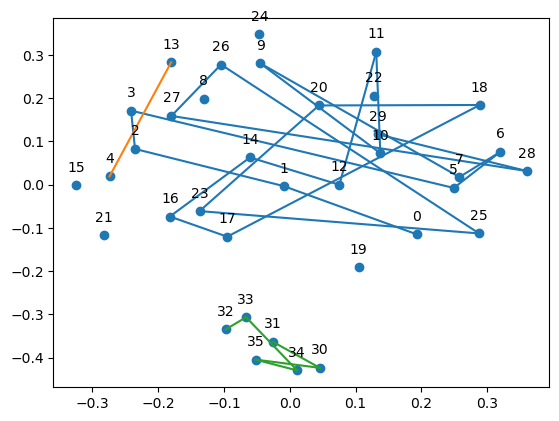

persistence =0.20001183301635272, finding: [11, 22]
 [[0, 1, 2, 3, 5, 6, 7, 9, 10, 11, 12, 14, 16, 17, 18, 20, 22, 23, 25, 26, 27, 28, 29], [4, 13], [32, 33, 34, 35, 30, 31]]
merging
[[22]]
[[0, 0]]
pbow:
[array([20.,  2.]), array([1., 0.]), array([0., 5.])]
[[ 0.         19.10497317 20.22374842]
 [19.10497317  0.          5.09901951]
 [20.22374842  5.09901951  0.        ]]
score x0.5166666666666667: [0.0] [0.0] [1.0] 
total score : 1.0

[[0, 1, 2, 3, 5, 6, 7, 9, 10, 11, 12, 14, 16, 17, 18, 20, 22, 23, 25, 26, 27, 28, 29], [4, 13], [32, 33, 34, 35, 30, 31]]


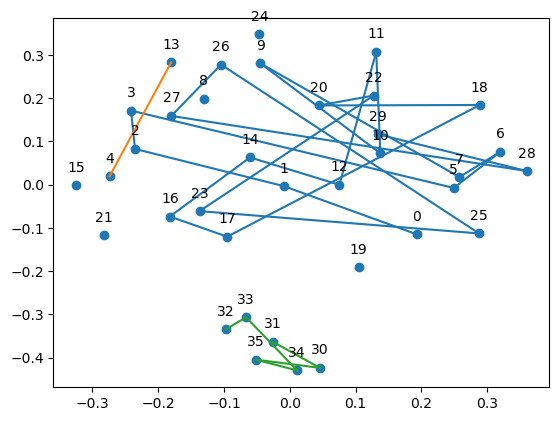

persistence =0.20165586322371187, finding: [4, 8]
 [[8, 4, 13], [0, 1, 2, 3, 5, 6, 7, 9, 10, 11, 12, 14, 16, 17, 18, 20, 22, 23, 25, 26, 27, 28, 29], [32, 33, 34, 35, 30, 31]]
merging
[[8]]
[[1, 0]]
pbow:
[array([0., 2., 0.]), array([ 0., 13.,  9.]), array([5., 0., 0.])]
[[ 0.         14.2126704   5.38516481]
 [14.2126704   0.         16.58312395]
 [ 5.38516481 16.58312395  0.        ]]
score x0.5333333333333333: [0.0] [0.0] [1.0] 
total score : 1.0

[[8, 4, 13], [0, 1, 2, 3, 5, 6, 7, 9, 10, 11, 12, 14, 16, 17, 18, 20, 22, 23, 25, 26, 27, 28, 29], [32, 33, 34, 35, 30, 31]]


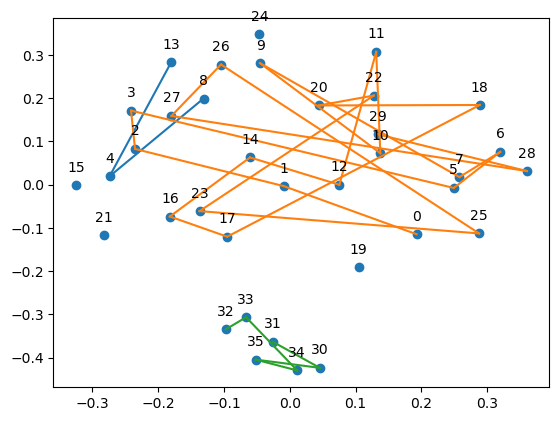

persistence =0.20608357261944732, finding: [14, 21]
 [[0, 1, 2, 3, 5, 6, 7, 9, 10, 11, 12, 14, 16, 17, 18, 20, 21, 22, 23, 25, 26, 27, 28, 29], [8, 4, 13], [32, 33, 34, 35, 30, 31]]
merging
[[21]]
[[1, 0]]
pbow:
[array([ 0., 14.,  9.]), array([0., 2., 0.]), array([5., 0., 0.])]
[[ 0.         15.         17.3781472 ]
 [15.          0.          5.38516481]
 [17.3781472   5.38516481  0.        ]]
score x0.55: [0.0] [0.0] [1.0] 
total score : 1.0

[[0, 1, 2, 3, 5, 6, 7, 9, 10, 11, 12, 14, 16, 17, 18, 20, 21, 22, 23, 25, 26, 27, 28, 29], [8, 4, 13], [32, 33, 34, 35, 30, 31]]


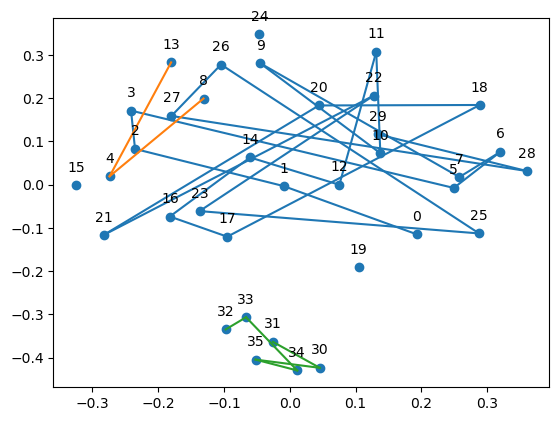

persistence =0.20781210609999667, finding: [8, 26]
 [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 17, 18, 20, 21, 22, 23, 25, 26, 27, 28, 29], [32, 33, 34, 35, 30, 31]]
merging
[[4, 8, 13], [0, 1, 2, 3, 5, 6, 7, 9, 10, 11, 12, 14, 16, 17, 18, 20, 21, 22, 23, 25, 26, 27, 28, 29]]
[[0, 0], [1, 0]]
[0, 1]
merging with pbow_d:  15.0 17.378147196982766
pbow:
[array([ 3., 13.,  0.,  6.,  4.]), array([0., 0., 5., 0., 0.])]
[[ 0.         15.96871942]
 [15.96871942  0.        ]]
score x0.55: [0.0] [1.0] 
total score : 1.0

[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 17, 18, 20, 21, 22, 23, 25, 26, 27, 28, 29], [32, 33, 34, 35, 30, 31]]


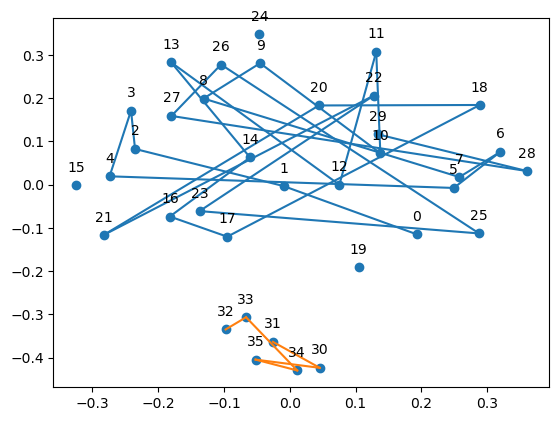

persistence =0.2241899222774426, finding: [4, 15]
 [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20, 21, 22, 23, 25, 26, 27, 28, 29], [32, 33, 34, 35, 30, 31]]
merging
[[15]]
[[0, 0]]
pbow:
[array([13.,  3.,  0.,  7.,  4.]), array([0., 0., 5., 0., 0.])]
[[ 0.         16.37070554]
 [16.37070554  0.        ]]
score x0.5666666666666667: [0.0] [1.0] 
total score : 1.0

[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20, 21, 22, 23, 25, 26, 27, 28, 29], [32, 33, 34, 35, 30, 31]]


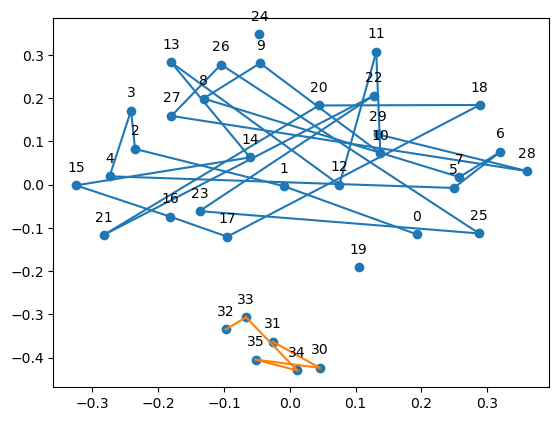

persistence =0.22858501291058708, finding: [24, 26]
 [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29], [32, 33, 34, 35, 30, 31]]
merging
[[24]]
[[0, 0]]
pbow:
[array([ 0., 13.,  7.,  3.,  5.]), array([5., 0., 0., 0., 0.])]
[[ 0.         16.64331698]
 [16.64331698  0.        ]]
score x0.5833333333333334: [0.0] [1.0] 
total score : 1.0

[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29], [32, 33, 34, 35, 30, 31]]


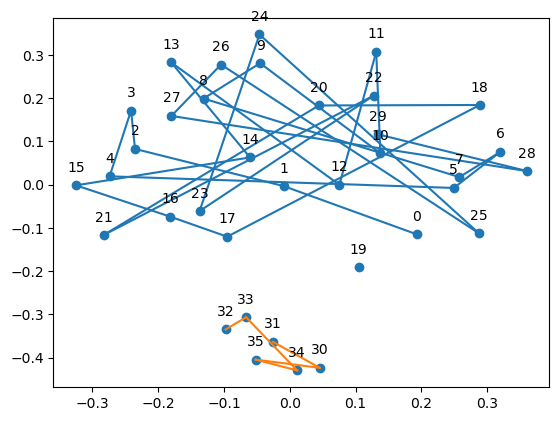

persistence =0.25819273167303614, finding: [17, 33]
 [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35]]
merging
[[30, 31, 32, 33, 34, 35], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]]
[[0, 0], [1, 0]]
[0, 1]
merging with pbow_d:  16.64331697709324 16.64331697709324
score x0.5833333333333334: [0.17142857142857143] 
total score : 0.8333333333333334



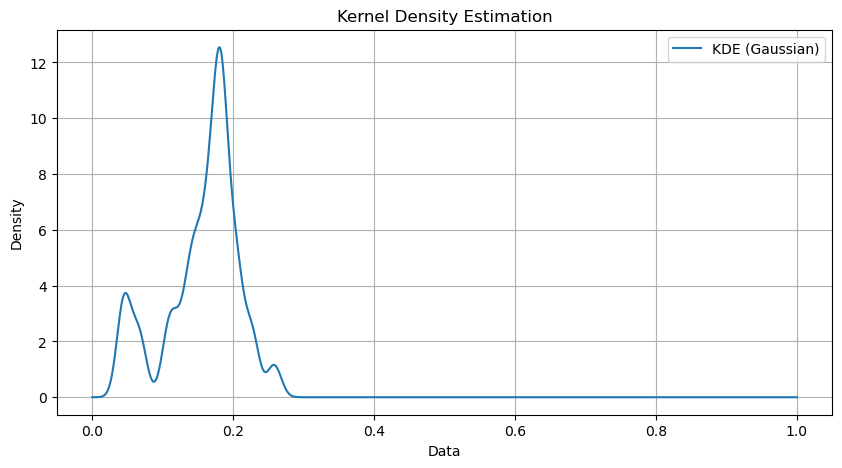

In [8]:
%matplotlib inline
for round_number, corr in corr_set:
    data = 1 - corr.reshape(-1, total_nums) - corr.reshape(-1, total_nums).T
    print(round_number, data.shape)
    # df=pd.DataFrame(data)
    # plot=seaborn.heatmap(df)
    # plt.show()
    sns.heatmap(1-data)
    plt.show()

    # Apply Multidimensional Scaling
    mds = MDS(n_components=2, dissimilarity='precomputed', random_state=1)
    mds_results = mds.fit_transform(data)

    # Plot the points
    plt.scatter(mds_results[:, 0], mds_results[:, 1])

    for i, points in enumerate(mds_results):
        plt.annotate(i, (points[0], points[1]), textcoords="offset points", xytext=(0,10), ha='center')
    plt.show()

    dv_seq = grouping(data, total_nums, normal_nums, mds_results)

    
    X = np.array([x for x in dv_seq if x != float('Inf')])
    X = X.reshape(-1, 1)

    # 初始化KDE模型
    kde = KernelDensity(kernel='gaussian', bandwidth=0.01).fit(X)

    # 进行密度估计
    X_sample = np.linspace(0, 1, 1000).reshape(-1, 1)
    log_dens = kde.score_samples(X_sample)

    plt.figure(figsize=(10, 5))
    plt.plot(X_sample, np.exp(log_dens), label='KDE (Gaussian)')
    plt.title('Kernel Density Estimation')
    plt.xlabel('Data')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True)
    plt.show()

    # plt.scatter(mds_results[:, 0], mds_results[:, 1])
    # for i, points in enumerate(mds_results):
    #     plt.annotate(i, (points[0], points[1]), textcoords="offset points", xytext=(0,10), ha='center')
    # plt.show()
